<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Classification Tutorial SWDB 2018 </h1> 
<h3 align="center">Tuesday, August 28, 2018</h3> 



This tutorial covers some general concepts in classification and highlights useful functionality in the sklearn package for performing classification.

Classification is closely related to regression. In the case of regression, we're trying to discover a mapping from independent continuous variables onto dependent continuous variables. In the case of classification, we're trying to discover a mapping from independent continous variables onto dependent categorical (i.e. discrete) variables. 

** Whereas regression attempts to find the best fit to the data, classification emphasizes finding the best boundaries to separate classes. **

One prominent use case in systems neuroscience is that **decoding is typically framed as a classification problem**. For example, mapping an activity vector (cell activity x number of neurons) onto some categorical feature that we believe is represented in that population activity. The category could be which stimulus out of a set of stimuli was presented on that trial, or the behavioral state of the animal (e.g. asleep versus awake, running versus stationary, engaged versus disengaged).



In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import neighbors

%matplotlib inline

sklearn.datasets provides the ability to generate synthetic data that have specific kinds of structure that are useful for understanding and validating the performance of various classification algorithms.

Here, we'll generate a 2D dataset with partial overlap.

In [3]:
X, y = datasets.make_classification(n_features=2,n_redundant=0,random_state=1,n_samples=1000)
        
print(np.shape(X))
print(np.shape(y))

(1000, 2)
(1000,)


Note that the shape of the training sets is X: (num_samples, num_dimensions) and y: (num_samples)

I wrote this function to easily visualize the datasets we'll generate in this tutorial.

In [4]:
def plot_classes(X,y):
    
    classes = np.unique(y)
    num_classes = len(classes)
    
    color = 'rbgmyk'
    
    plt.figure(figsize=(8,8))
    for cl in range(num_classes):
        plt.scatter(X[y==cl,0],X[y==cl,1],c=color[cl],edgecolor='none')
    plt.xlim(X[:,0].min(),X[:,0].max())
    plt.ylim(X[:,1].min(),X[:,1].max())
    plt.show()

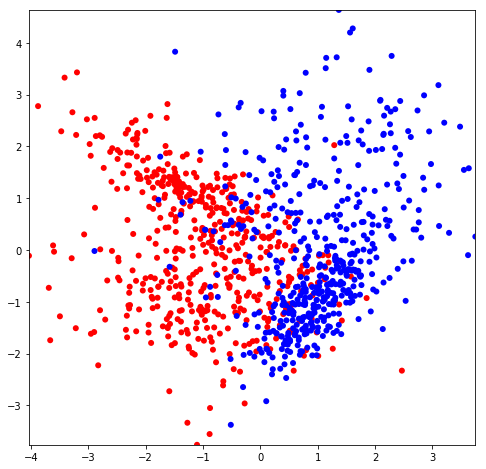

In [5]:
plot_classes(X,y)

It's important to split our data into a train and test set to ensure that our classifier can generalize to data that it hasn't yet seen. Again sklearn provides a straightforward function to make this split. Here, I'm telling the function that I want 20% of the data held-out for testing.

In [7]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

print(np.shape(X_train))
print(np.shape(y_train))

(800, 2)
(800,)


The first classification algorithm we'll try, and one typically worth trying first, is linear discriminant analysis. LDA will attempt to find a linear boundary between our classes.

In [8]:
classifier = LDA()
classifier.fit(X_train,y_train)
y_hat = classifier.predict(X_test)

I've written this function to visualize the test data that is correctly versus incorrectly classified.
Correctly classified data are displayed as filled circles,
   whereas incorrectly classified data are displayed as open circles.

In [9]:
def plot_test_performance(X,y,y_hat):
    
    classes = np.unique(y_test)
    num_classes = len(classes)
    
    color = 'rbgmyk'
    
    plt.figure(figsize=(8,8))
    for cl in range(num_classes):
        
        is_class = y == cl
        is_correct = y == y_hat
        
        plt.scatter(X[is_class & is_correct,0],X[is_class & is_correct,1],c=color[cl],edgecolor='none')
        plt.scatter(X[is_class & ~is_correct,0],X[is_class & ~is_correct,1],c='none',edgecolor=color[cl])
        
    plt.xlim(X[:,0].min(),X[:,0].max())
    plt.ylim(X[:,1].min(),X[:,1].max())
    plt.show()

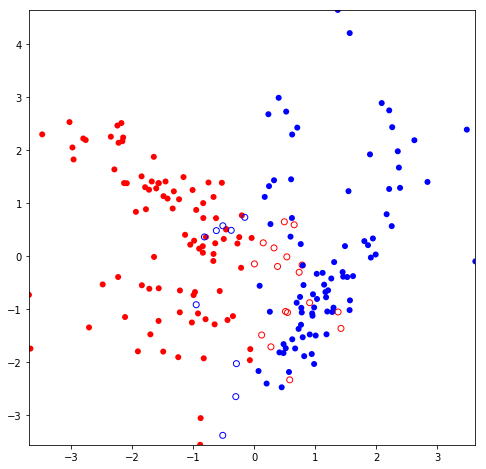

In [10]:
plot_test_performance(X_test,y_test,y_hat)

In order to visualize the actual decision boundary that was learned, this function will push many points on a grid through the classifier and display them.

In [11]:
def plot_classifier_boundary(classifier,X,num_classes=2):

    (grid_x1, grid_x2) = np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),80),np.linspace(X[:,1].min(),X[:,1].max(),80))
    grid = np.vstack([grid_x1.reshape(-1),grid_x2.reshape(-1)]).T
    grid_classes = classifier.predict(grid)   
    
    plot_classes(grid,grid_classes)

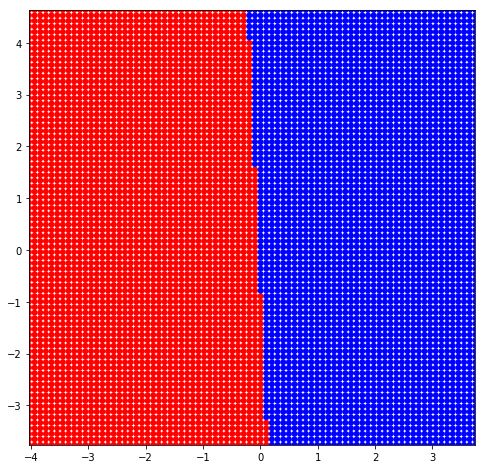

In [12]:
plot_classifier_boundary(classifier,X)

The classifier essentially learns to classify the data based on whether the first dimension is greater than or less than zero.

The next exercise illustrates an important aspect of training classifiers: since the classifier learns both the generalizable structure of the data that we're trying to capture as well as the specific variation (noise) in the training data, **the performance of a classifier can be no better on the test data than on the training data**. Typically, it's worse. This phenomenon is called **overfitting**.

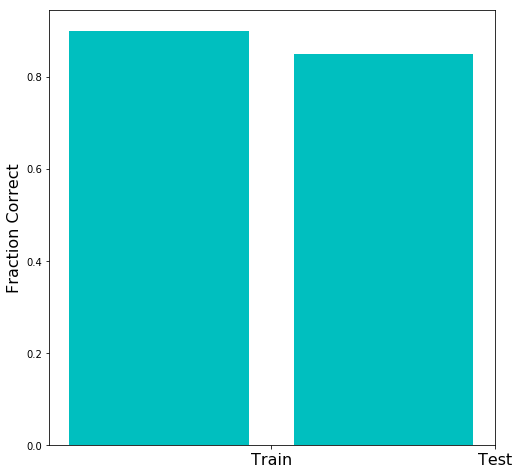

In [15]:
train_accuracy = []
test_accuracy = []
num_folds = 5

X, y = datasets.make_classification(n_features=2,n_redundant=0,random_state=0,n_samples=20)

scores = model_selection.cross_validate(classifier,X,y, cv=5, return_train_score=True)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.bar([0,1],[np.mean(scores['train_score']),np.mean(scores['test_score'])],color='c')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Train','Test'],fontsize=16)
ax.set_ylabel('Fraction Correct',fontsize=16)
plt.show()

Try playing with the number of samples in the dataset above. You'll notice that the gap between the performance on train and test sets gets smaller as the dataset gets larger. That happens because the sample dataset begins to look more like the full population, so large train and test set should have very similar distributions. In other words, as the training set becomes infinitely large, it becomes impossible that the test set encounters a part of the distribution that is not represented in the train set.

Next, let's try a dataset that isn't so easily separated by a linear classifier.

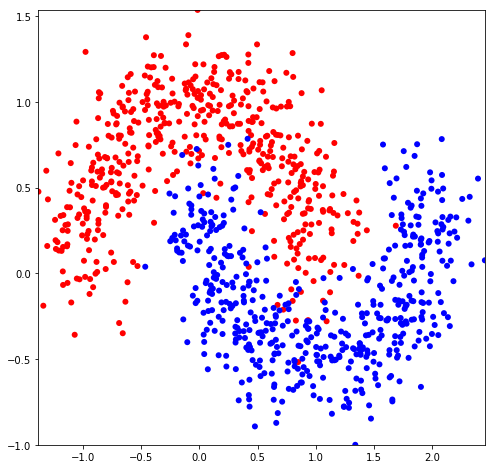

In [16]:
X, y = datasets.make_moons(noise=0.2,random_state=0,n_samples=1000)
    
plot_classes(X,y)

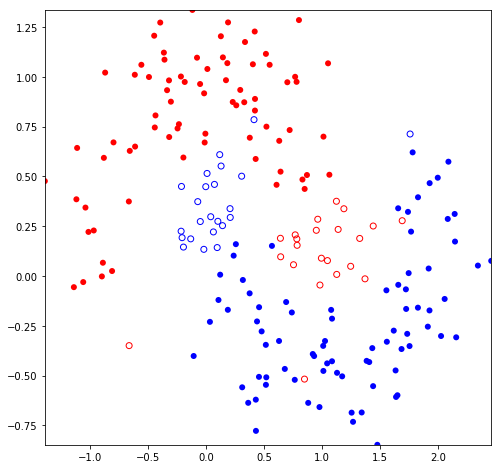

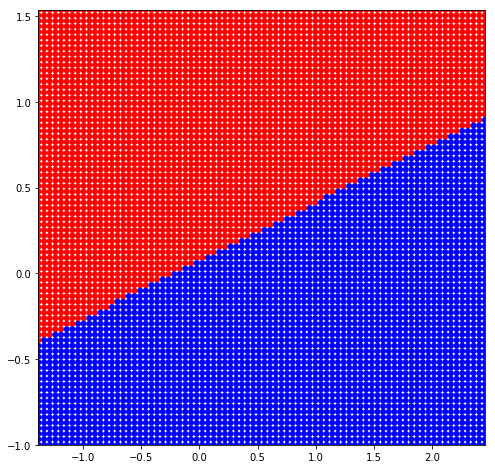

In [17]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

classifier = LDA()
classifier.fit(X_train,y_train)
y_hat_lda = classifier.predict(X_test)

plot_test_performance(X_test,y_test,y_hat_lda)
plot_classifier_boundary(classifier,X)

Let's try a non-linear classifier. K-nearest neighbors is a very straightforward non-linear classifier that just uses the class mode of the closest data points in the training set.

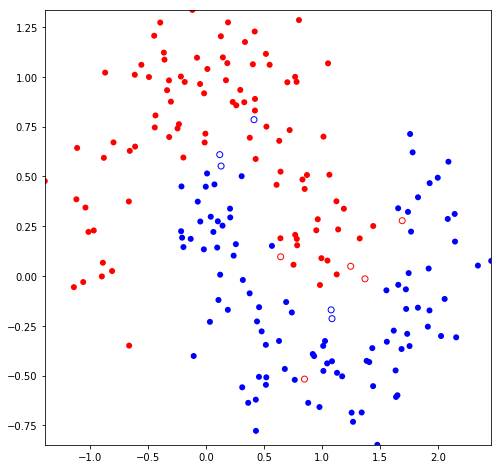

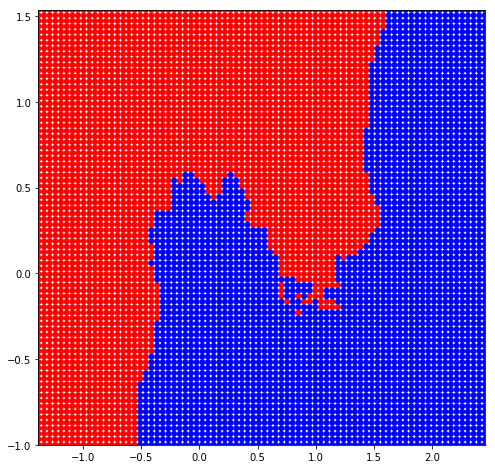

In [18]:
classifier = neighbors.KNeighborsClassifier()
classifier.fit(X_train,y_train)

y_hat_knn = classifier.predict(X_test)

plot_test_performance(X_test,y_test,y_hat_knn)
plot_classifier_boundary(classifier,X)

The performance of the KNN classifier depends on the number of neighbors that are considered for deciding class membership. We can determine the best value of K through **validation**.

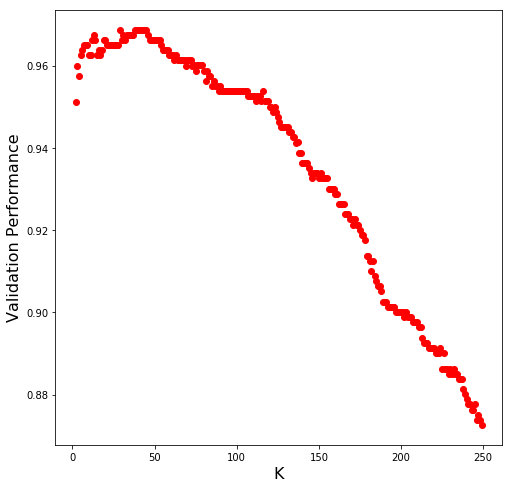

In [21]:
k_to_try = np.arange(2,250,1)
val_performance = np.zeros(np.shape(k_to_try))
for ki, k in enumerate(k_to_try):
    
    classifier = neighbors.KNeighborsClassifier(n_neighbors=k)

    scores = model_selection.cross_validate(classifier,X_train,y_train, cv=3)
    
    val_performance[ki] = np.mean(scores['test_score'])

plt.figure(figsize=(8,8))
plt.plot(k_to_try,val_performance,'ro')
plt.xlabel('K',fontsize=16)
plt.ylabel('Validation Performance',fontsize=16)
plt.show()

Now let's use the best value of K from validation to see how well it generalizes to the hold-out test set.

In [26]:
best_K = k_to_try[np.argmax(val_performance)]

classifier = neighbors.KNeighborsClassifier(n_neighbors=best_K)
classifier.fit(X_train,y_train)

y_hat = classifier.predict(X_test)
 
print("Best K: " + str(best_K))
print("Validation Performance: " + str(val_performance.max()))
print("Test Performance: " + str(np.mean(y_test == y_hat)))

Best K: 29
Validation Performance: 0.9687371413608649
Test Performance: 0.96


Let's quantitatively compare the performance of LDA and KNN.

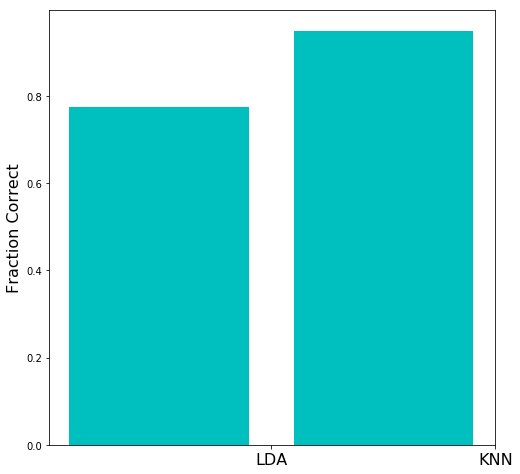

In [27]:
test_accuracy = np.array([
                          (y_test==y_hat_lda).mean(),
                          (y_test==y_hat_knn).mean()
                        ])

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.bar([0,1],test_accuracy,color='c')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['LDA','KNN'],fontsize=16)
ax.set_ylabel('Fraction Correct',fontsize=16)
plt.show()

There are many more types of datasets you can make with scikit-learn, many of which are not linearly classifiable.

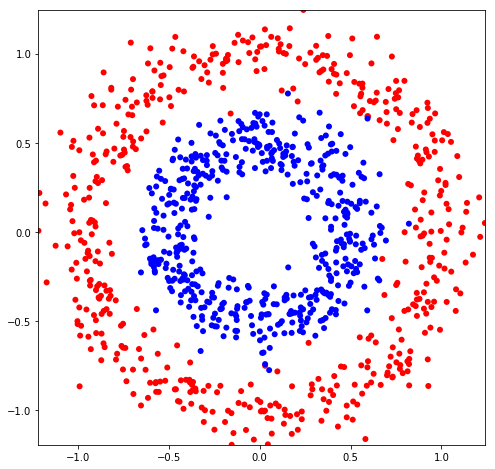

In [28]:
X, y = datasets.make_circles(noise=0.1, factor=0.5, random_state=1,n_samples=1000)
    
plot_classes(X,y)

Now let's look at a dataset with more than two classes.

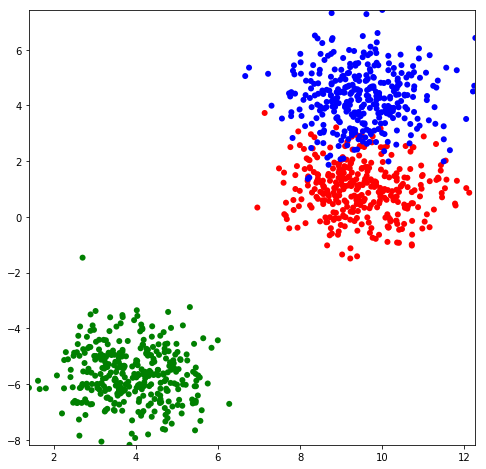

In [29]:
X, y = datasets.make_blobs(n_features=2, centers=3,random_state=4,n_samples=1000)
       
plot_classes(X,y)

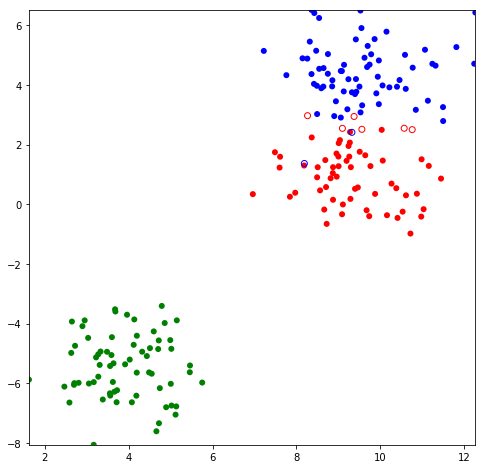

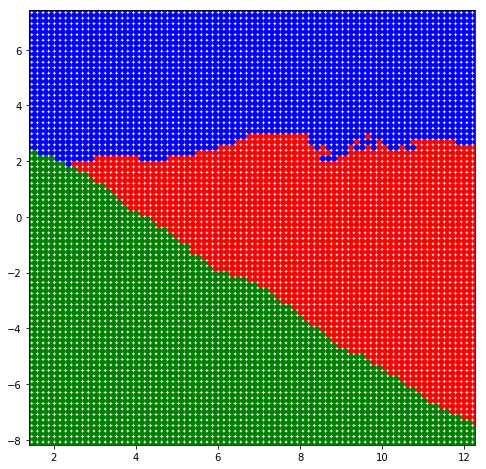

In [32]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

classifier = neighbors.KNeighborsClassifier()
classifier.fit(X_train,y_train) 
y_hat = classifier.predict(X_test)

plot_test_performance(X_test,y_test,y_hat) 
plot_classifier_boundary(classifier,X)

Note that the red and blue classes overlap, but neither overlaps with the green class. One method commonly used to determine which classes are more difficult for a classifier to distinguish is to make a "confusion matrix." This is simply a matrix comparing the actual class a datapoint belongs to the class that is predicted by the classifier.

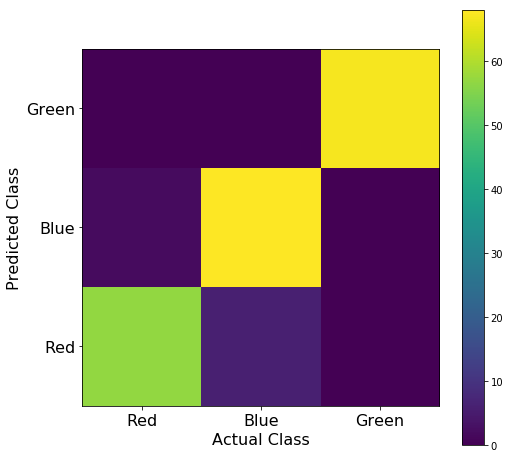

In [33]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(y_test,y_hat)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none',origin='lower',vmin=0,vmax=C.max())
ax.set_xlabel('Actual Class',fontsize=16)
ax.set_ylabel('Predicted Class',fontsize=16)
ax.set_xticks(range(3))
ax.set_xticklabels(['Red','Blue','Green'],fontsize=16)
ax.set_yticks(range(3))
ax.set_yticklabels(['Red','Blue','Green'],fontsize=16)
plt.colorbar(cax)

Side note: Classification is related to another technique called clustering. Classification is performed when you have class labels, whereas clustering is performed when you do not. The former is known as supervised learning and the latter is known as unsupervised learning.

Here's an example, attempting to cluster the datapoints from the previous example:

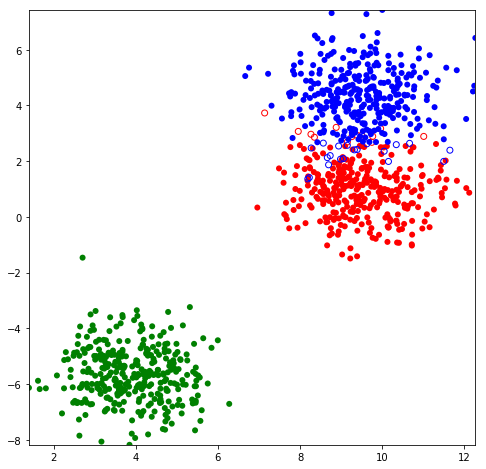

In [34]:
from sklearn.cluster import KMeans
from scipy import stats

kmeans = KMeans(n_clusters=3).fit(X)
unsupervised_y_hat = kmeans.labels_

class_0, __ = stats.mode(unsupervised_y_hat[y==0])
class_1, __ = stats.mode(unsupervised_y_hat[y==1])
class_2, __ = stats.mode(unsupervised_y_hat[y==2])

sorted_unsup_y_hat = unsupervised_y_hat.copy()
sorted_unsup_y_hat[unsupervised_y_hat==class_0] = 0
sorted_unsup_y_hat[unsupervised_y_hat==class_1] = 1
sorted_unsup_y_hat[unsupervised_y_hat==class_2] = 2

plot_test_performance(X,y,sorted_unsup_y_hat)

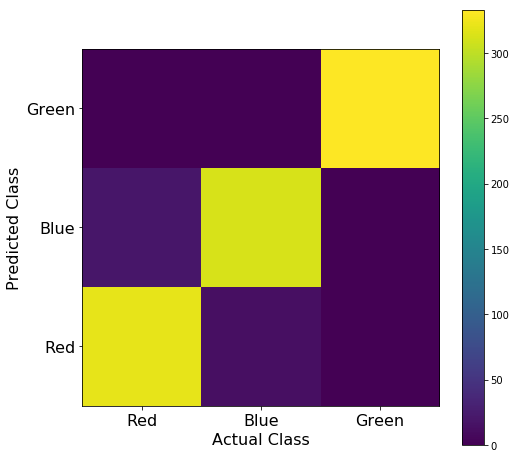

In [35]:
C = confusion_matrix(y,sorted_unsup_y_hat)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none',origin='lower',vmin=0,vmax=C.max())
ax.set_xlabel('Actual Class',fontsize=16)
ax.set_ylabel('Predicted Class',fontsize=16)
ax.set_xticks(range(3))
ax.set_xticklabels(['Red','Blue','Green'],fontsize=16)
ax.set_yticks(range(3))
ax.set_yticklabels(['Red','Blue','Green'],fontsize=16)
plt.colorbar(cax)

Note: In general, class labels provide important information about where exactly class boundaries should be drawn. Unsupervised learning must rely on the natural breaks in the data, which might be difficult to find under noisy conditions.

Finally, let's try a decision tree classifier. Decision trees are useful because the results are easily interpreted by human beings. In the end, you get a series of choices on the values of individual features that tell you which class to assign any given datapoint to. They're called decision trees because you always start at the same point ("the root") and each consecutive choice leads you down a particular branch, until you arrive at a class assignment ("the leaves").

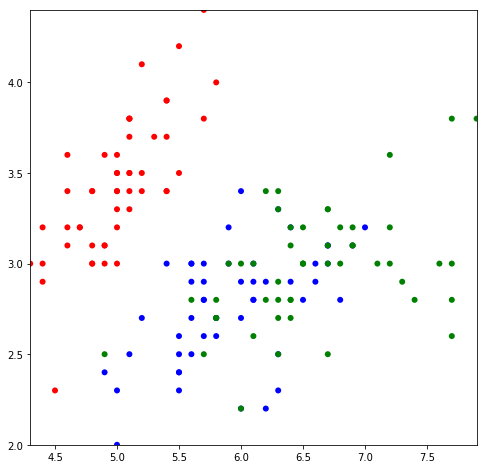

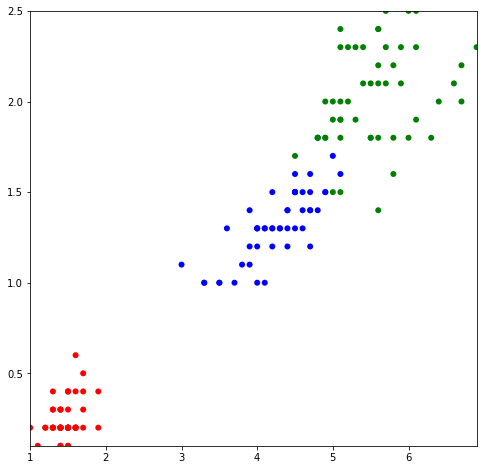

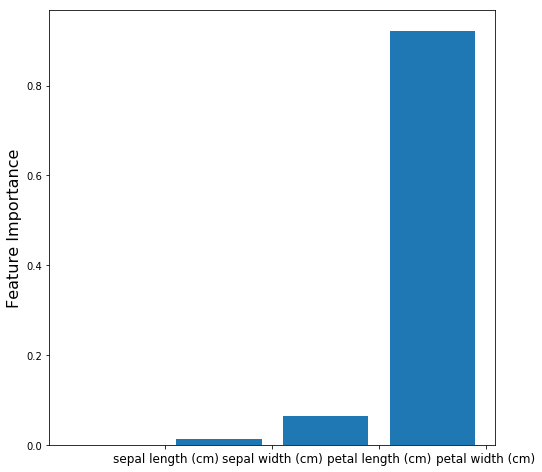

In [36]:
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()

classifier = DecisionTreeClassifier(random_state=0)
classifier = classifier.fit(iris.data, iris.target)

#plot first versus second dimension
plot_classes(iris.data[:,[0,1]],iris.target)

#plot third versus fourth dimension
plot_classes(iris.data[:,[2,3]],iris.target)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.bar(range(4),classifier.feature_importances_)
ax.set_xticks(np.arange(4)+0.5)
ax.set_xticklabels(iris.feature_names,fontsize=12)
ax.set_ylabel('Feature Importance',fontsize=16)
plt.show()

Feature importance (see "Gini Importance") gives a sense of how heavily each feature is weighted in the decision tree. In this case, overlap of classes by petal width is only slightly smaller than overlap in petal length, but that slight difference is enough for the decision tree to prioritize using petal width before considering petal length, so their relative importance is highly rectified.

Below is a visualization of the tree structure of the decision process:

<img src="tree.png">

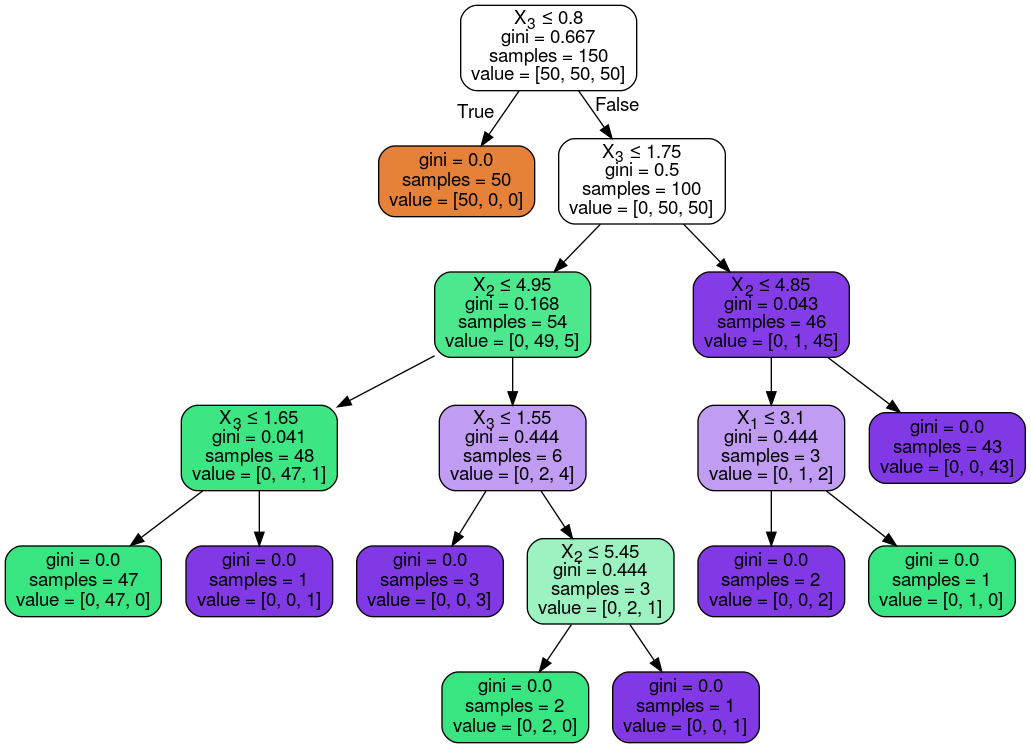

In [39]:
# NOTE YOU NEED TO... pip install pydotplus to make this work

from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())